# Modeling Risk Taking

In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import random

In [3]:
dfs = []
for d in Path("data/").iterdir():
    df = pd.read_csv(d, index_col=0)
    df["participant_id"] = d.stem
    df["trial_id"] = np.arange(len(df))
    dfs.append(df)


all_data = pd.concat(dfs, ignore_index=True)
all_data

,nPumps,popped,maxPumps,participant_id,trial_id
0,8.0,True,8.0,2259b8fc,0
1,6.0,False,14.0,2259b8fc,1
2,2.0,True,2.0,2259b8fc,2
3,8.0,False,20.0,2259b8fc,3
4,10.0,False,26.0,2259b8fc,4
...,...,...,...,...,...
295,8.0,True,8.0,49wpk5jb,20
296,2.0,True,2.0,49wpk5jb,21
297,2.0,True,2.0,49wpk5jb,22
298,26.0,True,26.0,49wpk5jb,23


In [4]:
banked_trials = all_data[all_data["popped"] == False]
adjusted_scores = banked_trials.groupby("participant_id")["nPumps"].mean().rename("mean_nPumps")
adjusted_scores

participant_id
09peo2oi     9.357143
1tm3byp0     9.750000
2259b8fc    12.153846
49wpk5jb    10.583333
gap81oy1     9.500000
gc3m8i3m     9.444444
kvkvbai2    10.230769
ml56yp41     8.687500
odgq13lt    13.300000
rj31hfqr     7.312500
s7yj6rcb    11.750000
z4wu6x73     7.875000
Name: mean_nPumps, dtype: float64

<Axes: xlabel='participant_id'>

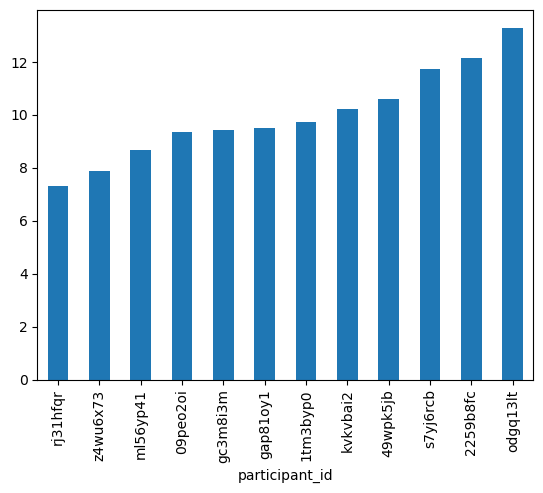

In [7]:
adjusted_scores.sort_values().plot(kind="bar")

In [8]:
all_data["pid"] , p_id_map = all_data["participant_id"].factorize()
all_data

,nPumps,popped,maxPumps,participant_id,trial_id,pid
0,8.0,True,8.0,2259b8fc,0,0
1,6.0,False,14.0,2259b8fc,1,0
2,2.0,True,2.0,2259b8fc,2,0
3,8.0,False,20.0,2259b8fc,3,0
4,10.0,False,26.0,2259b8fc,4,0
...,...,...,...,...,...,...
295,8.0,True,8.0,49wpk5jb,20,11
296,2.0,True,2.0,49wpk5jb,21,11
297,2.0,True,2.0,49wpk5jb,22,11
298,26.0,True,26.0,49wpk5jb,23,11


# The Model

- the adjusted pumps measure: the mean number of pumps for *banked trials*

Assumptions:
- on each trial the participants' intended number of pumps is sampled from a truncated Gaussian distribution with mean $\rho_p$ and standard deviation $\beta_p$ for participant $p$
- number of pumps = non-negative integer = truncated Gaussian rounded to the nearest whole number
- the intended number of pumps for participant $p$ on the trial $t$: $y'_t$
- $b_t$: the right censoring value, i.e. number of pumps it takes for the balloon to burst on trial $t$
- $\rho_i$ and $\beta_i$: priors for participant $i$
$$
\begin{align*}
y'_t &\sim \lfloor Gaussian_+(\rho_{p_t}, \beta_{p_t}) \rceil
\\
y_t &= \begin{cases} y_t' &\text{if} \quad y_t' <b_t \\ b_t &\text{if} \quad y_t' \geq b_t \end{cases}
\\
\rho_i &\sim Gaussian_+(0,100) 
\\
\beta_i &\sim Gaussian_+(0,100)

\end{align*}
$$

"
Our goal is to use censoring to measure the distribution of intended pumps for individual participants based on their behavior over a set of BART trials. We assume the distribution is Gaussian, but truncated to be non-negative. The mean of the distribution naturally corresponds to a simple measure of the overall risk propensity of the individual. The variability of the distribution provides a measure of the behavioral consistency of risk propensity from trial to trial.
"

In [11]:
n_participants = len(all_data["participant_id"].unique())

with pm.Model() as m:
    rho = pm.TruncatedNormal('rho', 10, 5, shape=n_participants, lower=0)
    beta = pm.TruncatedNormal('beta', 3, 2, shape=n_participants, lower=0)

    intended = pm.Normal.dist(mu=rho[all_data["pid"]], sigma=beta[all_data["pid"]])

    pump = pm.Censored(
        "pump",
        intended,
        lower=None,
        upper=all_data["maxPumps"],
        observed=all_data["nPumps"],
    )

m_graph = pm.model_to_graphviz(m)

with m:
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


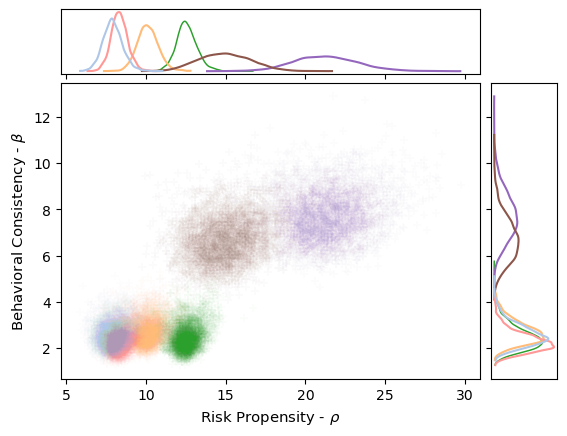

In [16]:
idata_posterior = idata.posterior.stack(sample=("chain", "draw"))

colors = plt.get_cmap("tab20").colors  

sampled_colors = random.sample(list(colors), 11)

sample_array = np.arange(0,n_participants)

first_sample = random.sample(list(sample_array), 1)[0]

rest_samples = sample_array[sample_array!=first_sample]

ax = az.plot_pair(
        idata,
        marginals=True,
        group='posterior',
        var_names=["rho", "beta"],
        kind='scatter',
        textsize=10,
        scatter_kwargs={'marker': 'P', 'facecolors': colors[first_sample], 'alpha': 0.02},
        marginal_kwargs={"color": colors[first_sample]},
        coords={"rho_dim_0": first_sample,
                "beta_dim_0": first_sample},
    )

n_plotted = 6
plot_samples = random.sample(list(rest_samples), n_plotted-1)

for i in plot_samples:
    az.plot_pair(
        idata,
        marginals=False,
        group='posterior',
        var_names=["rho", "beta"],
        kind='scatter',
        textsize=10,
        scatter_kwargs={'marker': 'P', 'facecolors': colors[i], 'alpha': 0.02},
        coords={"rho_dim_0": i,
                "beta_dim_0": i,},
        ax=ax[1, 0]
    )

    az.plot_dist(idata_posterior.sel(beta_dim_0=i).beta, color=colors[i], rotated=True, ax=ax[1,1])
    az.plot_dist(idata_posterior.sel(rho_dim_0=i).rho, color=colors[i], rotated=False, ax=ax[0,0])

ax[1, 0].set_ylabel(r"Behavioral Consistency - $\beta$")
ax[1, 0].set_xlabel(r"Risk Propensity - $\rho$");

In [17]:
quest_df = pd.read_csv("questionnaire.csv", index_col=0)
quest_df

,participant_id,smoking,coffee,sleep,alcohol
0,09peo2oi,never,1.0,6,0
1,odgq13lt,former,2.0,8,1
2,s7yj6rcb,current,1.0,6,0
3,kvkvbai2,current,2.0,7,2
4,rj31hfqr,never,1.5,7,0
5,1tm3byp0,never,2.0,7,2
6,z4wu6x73,never,6.0,7,3
7,ml56yp41,never,0.0,8,2
8,49wpk5jb,current,2.0,6,6
9,gc3m8i3m,former,2.0,7,4


In [18]:
def add_smoker(row):
    if row["smoking"] == " never":
        return 0
    else:
        return 1

quest_df["smoke_id"] = quest_df.apply(add_smoker, axis=1, result_type="expand")
quest_df

,participant_id,smoking,coffee,sleep,alcohol,smoke_id
0,09peo2oi,never,1.0,6,0,0
1,odgq13lt,former,2.0,8,1,1
2,s7yj6rcb,current,1.0,6,0,1
3,kvkvbai2,current,2.0,7,2,1
4,rj31hfqr,never,1.5,7,0,0
5,1tm3byp0,never,2.0,7,2,0
6,z4wu6x73,never,6.0,7,3,0
7,ml56yp41,never,0.0,8,2,0
8,49wpk5jb,current,2.0,6,6,1
9,gc3m8i3m,former,2.0,7,4,1


In [19]:
quest_df.smoke_id.sum() / len(quest_df)

0.5

In [20]:
def combine_smoker(row):
    return quest_df[quest_df["participant_id"]==row["participant_id"]]["smoke_id"].values[0]
all_data["smoker"] = all_data.apply(combine_smoker, axis=1, result_type="expand")

In [21]:
z_i = []
for i in p_id_map:
    z_i.append(quest_df[quest_df["participant_id"]==i]["smoke_id"].values[0])

z_i

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1]

In [22]:
with pm.Model() as m_group:
    delta = pm.Normal("delta", mu=0, sigma=10) # difference prior
    mu_g = pm.LogNormal("mu_g", mu=2.4, sigma=0.5) # grand mean prior
    
    beta = pm.Exponential( # behavioral consistency prior (independent of group)
        "beta", lam=0.5, shape=n_participants, dims=("participant_id")
    )

    mu_1 = pm.Deterministic("mu_1", mu_g - delta/2.0) #nonsmoker
    mu_2 = pm.Deterministic("mu_2", mu_g + delta/2.0) #smoker

    mu = pm.math.stack([mu_1, mu_2])
    sigma = pm.Exponential("sigma", lam=1, shape=2, dims=("groups"))

    rho = pm.TruncatedNormal("rho", mu=mu[z_i], sigma=sigma[z_i], lower=0, shape=n_participants, dims=("participant_id"))
    
    intended = pm.Normal.dist(mu=rho[all_data["pid"]], sigma=beta[all_data["pid"]])

    pump = pm.Censored(
        "pump",
        intended,
        lower=None,
        upper=all_data["maxPumps"],
        observed=all_data["nPumps"],
    )

with m_group:
    idata_group = pm.sample(target_accept=0.95)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, mu_g, beta, sigma, rho]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


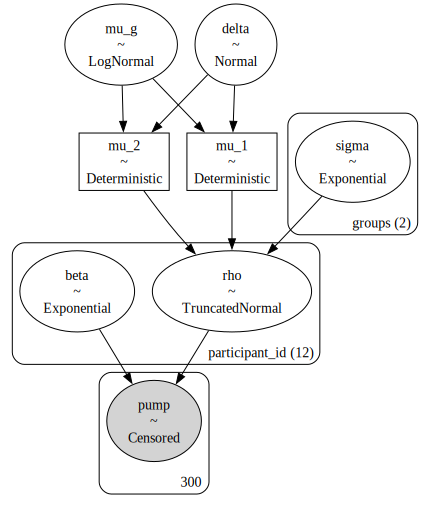

In [25]:
m_group_graph = pm.model_to_graphviz(m_group)
m_group_graph

In [23]:
az.summary(idata_group)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,1.909,1.985,-1.836,5.684,0.050,0.039,1578.0,1822.0,1.00
mu_g,12.162,1.005,10.184,14.055,0.025,0.018,1599.0,1487.0,1.00
beta[0],3.571,0.681,2.328,4.774,0.013,0.009,2881.0,858.0,1.00
beta[1],2.485,0.468,1.729,3.362,0.010,0.007,2602.0,2009.0,1.00
beta[2],4.067,0.858,2.651,5.696,0.017,0.013,3250.0,2310.0,1.00
beta[3],2.561,0.505,1.700,3.527,0.009,0.007,4049.0,2442.0,1.00
beta[4],2.359,0.516,1.506,3.328,0.009,0.007,3408.0,2719.0,1.00
beta[5],1.173,0.227,0.789,1.595,0.004,0.003,3837.0,2038.0,1.00
beta[6],5.561,0.979,3.894,7.427,0.017,0.012,3469.0,2562.0,1.00
beta[7],2.165,0.415,1.443,2.924,0.008,0.006,3200.0,2368.0,1.00


<Axes: title={'center': 'delta'}>

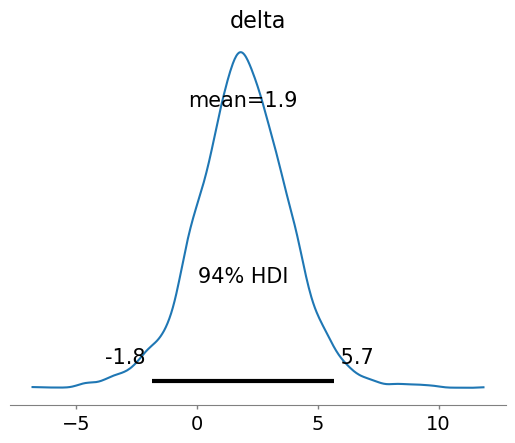

In [26]:
az.plot_posterior(idata_group, var_names="delta")

In [27]:
beta_summary = az.summary(idata_group.posterior.beta, hdi_prob=0.95)
rho_summary = az.summary(idata_group.posterior.rho, hdi_prob=0.95)

In [28]:
c = np.array(["k","r"])
c[z_i]

array(['k', 'k', 'r', 'k', 'r', 'k', 'r', 'k', 'k', 'r', 'r', 'r'],
      dtype='<U1')

/var/folders/_x/c00gpvvj08144m_76ng172dh0000gn/T/ipykernel_12563/668083157.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


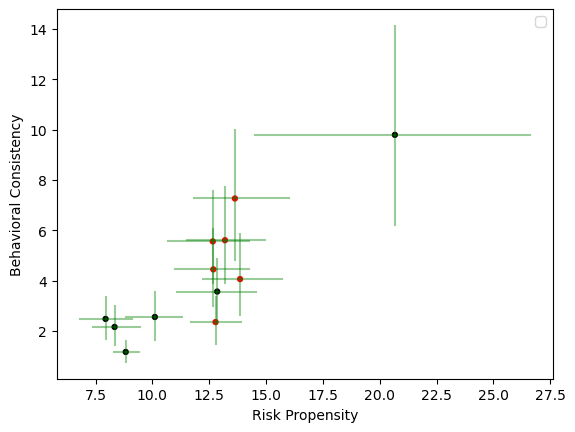

In [33]:
fig, ax = plt.subplots()
xvals = rho_summary["mean"].values
yvals = beta_summary["mean"].values

ax.scatter(xvals, yvals, marker=".", color=c[z_i], s=50)

ylows = beta_summary["hdi_2.5%"].values
yhighs = beta_summary["hdi_97.5%"].values
xlows = rho_summary["hdi_2.5%"].values
xhighs = rho_summary["hdi_97.5%"].values


for n in range(len(xvals)):
    # vertical line (psi posterior)
    plt.plot([xvals[n], xvals[n]], [ylows[n], yhighs[n]], 'g', alpha=0.4)
    # horizontal line (rho posterior)
    plt.plot([xlows[n], xhighs[n]], [yvals[n], yvals[n]], 'g', alpha=0.4)

# plt.xlim([0, 15])
# plt.ylim([6, 42])

plt.xlabel('Risk Propensity')
plt.ylabel('Behavioral Consistency');
plt.legend()

Sampling: [beta, delta, mu_g, pump, rho, sigma]


({'BF10': 0.3082105563509978, 'BF01': 3.2445352029447534},
 <Axes: title={'center': 'The BF_10 is 0.31\nThe BF_01 is 3.24'}, xlabel='delta', ylabel='Density'>)

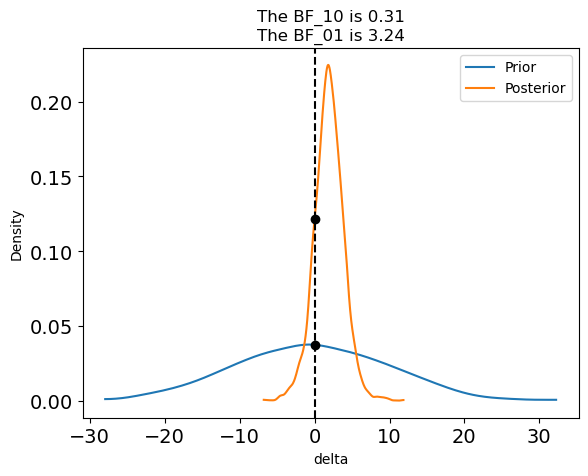

In [34]:
with m_group:
    idata_group.extend(pm.sample_prior_predictive(1000))
az.plot_bf(idata_group, var_name="delta")

Savage-Dickey method can be used to compute a Bayes factor comparing the hypothesis that the difference between the groups is zero to the alternative that the difference is non-zero. The Bayes factor is approximately 3 in favor of the alternative hypothesis. We take this as anectodal evidence that the group means for risk propensity are different between non-smokers and smokers.

# Interpreting a Bayes factor of 3

A Bayes factor of $BF_{10} = 3$ means that the observed data are about three times more likely under the alternative hypothesis $H_1$ than under the null hypothesis $H_0$. Formally,

$BF_{10} = 3 \Rightarrow \frac{p(\text{data} \mid H_1)}{p(\text{data} \mid H_0)} = 3.$

That is, the model in the numerator of the Bayes factor (here $H_1$) is better supported by the data than the model in the denominator (here $H_0$) by a factor of 3.

In terms of strength of evidence, a Bayes factor of about 3 is typically interpreted as *moderate but not strong* evidence in favor of $H_1$ over $H_0$. It indicates that the data provide some support for the alternative hypothesis, but the evidence is far from decisive.
